# Earthquake Catastrophe Risk Model
## Danyang Jiang, Haonan Yang, Vincent Brely-Demeules

### Basic import

In [1]:
## basic imports ##
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
from scipy.stats import norm
import pandas as pd
import math
from scipy import special
from scipy.stats import lognorm

### Function that will be used later

In [2]:
## function defined for later use

def discretize(fault_now, dL = 0.1): # generate points for faults with a given interval dL=0.1km
    fault_now = fault_now.reset_index(drop = True) # re-index
    num_df = fault_now.TOTALL.count() - 1 # number of segment for the current fault
    
    for i in range(num_df):
        dis_num = math.ceil(fault_now.at[i+1, 'DIS'] / dL)
        dL_real = fault_now.at[i+1, 'DIS'] / dis_num
        
        x_add = np.linspace(fault_now.at[i, 'POINT_X'], fault_now.at[i+1, 'POINT_X'], dis_num+1)
        y_add = np.linspace(fault_now.at[i, 'POINT_Y'], fault_now.at[i+1, 'POINT_Y'], dis_num+1)
        
        template = pd.concat([fault_now.head(1)] * (dis_num+1))
        
        template['POINT_X'] = x_add
        template['POINT_Y'] = y_add
        template['DIS'] = dL_real
        
        if i == 0:
            final_df = template.copy()
        else:
            final_df = final_df.append(template)
    
    final_df.drop_duplicates(subset=['POINT_X', 'POINT_Y'], inplace=True, ignore_index = True)
        
    return final_df

def get_magnitude(L, a = 5.08, b = 1.16):
    M = a + b * np.log10(L)
    return M

def get_length(M, a = 5.08, b = 1.16): # check textbook 53
    L = 10 ** ((M - a)/b)
    return L

def get_rate(M, a = 5, b = 1, dM = 0.1): # from slides P49, to calculate ratei
    rate = np.power(10, (a - b * (M - dM / 2))) - np.power(10, (a - b * (Mi + dM / 2)))
    return rate

def min_dis(point, event_df): # calculate minimum distance when fault is projected to the ground
    return min(np.sqrt( np.square(event_df.POINT_X - point[0]) + np.square(event_df.POINT_Y - point[1]) ))

def get_intensity(m, r, h = 6): # from the literature, author use h=6km for best estimation
    real_distance = np.sqrt(np.square(r) + np.square(h)) # consider depth
    return np.power(10, (-1.34 + 0.23 * m - np.log10(real_distance)))

def get_MDRgrid(I_grid, B_grid):
    
    B_mean_grid = np.zeros(B_grid.shape)
    B_mean_grid[np.where(B_grid == 1)] = MA_E
    B_mean_grid[np.where(B_grid == 2)] = RC_E

    B_std_grid = np.zeros(B_grid.shape)
    B_std_grid[np.where(B_grid == 1)] = np.sqrt(MA_Var)
    B_std_grid[np.where(B_grid == 2)] = np.sqrt(RC_Var)
    
    MDR_grid = lognorm.cdf(I_grid * g, s = B_std_grid, scale=np.exp(B_mean_grid))
    MDR_grid = np.nan_to_num(MDR_grid)
    
    return MDR_grid

def get_hazrad_curve(I_range, I_mean, nev):
    nIr = len(I_range)
    # predefined value for calculation
    sigma = 0.27
    
    rate_perev_perI = np.zeros([nev, nIr])
    
    for i in range(nev):
        Pr_exceed = 1 - norm.cdf(np.log10(I_range), np.log10(I_mean[i]), sigma)
        rate_perev_perI[i,:] = ratei[i] * Pr_exceed
    rate_all = rate_perev_perI.sum(axis = 0)
    Pr = 1 - np.exp(-rate_all)
    
    return Pr

def get_PGA4hazard_map(T_ret, I_range, I_mean, nev):
    
    Pr = get_hazrad_curve(I_range, I_mean, nev)
    ab = np.abs(Pr - 1/T_ret)
    ind = ab.argmin()
    closest_PGA = I_range[ind]
    
    return closest_PGA

def eliminate_zero(x):
    mask = (x==0).all(0)
    # column_idx = np.where(mask)[0]
    x = x[:, ~mask]
    x = x.T
    mask = (x==0).all(0)
    x = x[:, ~mask]
    
    return x.T

### Define our study area (100km*100km)

In [3]:
## define the study area

xmin = 0; xmax = 100; dx = 1; 
ymin = 0; ymax = 100; dy = 1;

x = np.arange(xmin,xmax,dx)
y = np.arange(ymin,ymax,dy)
grid = np.meshgrid(x, y)

# flatten the coordinates
grid_x = list(itertools.chain(*grid[0]))
grid_y = list(itertools.chain(*grid[1]))
#plt.plot(grid_x, grid_y, marker='.', color='grey', linestyle='none') # to check whether the flatten success or not


### Read the faults distribution model and discretize the faults

In [4]:
# discretize faults to 0.1km
faults_org = pd.read_csv('./POINTS.csv')
x_f = 111.32 * faults_org['POINT_X'].diff() * np.cos(faults_org['POINT_Y'].diff()/np.pi/180)
y_f = 110.574 * faults_org['POINT_Y'].diff()
faults_org.insert(loc=len(faults_org.columns),column='DIS', value=np.sqrt(x_f**2+y_f**2))

# set the 'DIS' to 0 at initial point for every fault
faults_ini_idx = [faults_org[faults_org['IDSOURCE'] == i].index[0] for i in faults_org.IDSOURCE.unique()]
for i in faults_ini_idx:
    faults_org.at[i, 'DIS'] = 0

faults_org = faults_org.loc[:, ['IDSOURCE', 'TOTALL', 'POINT_X', 'POINT_Y', 'DIS']] # extrace useful columns
dL = 0.1 # discretization resolution
faults = pd.DataFrame()

for i in faults_org['IDSOURCE'].unique():
    fault_now = faults_org[faults_org['IDSOURCE'] == i]
    faults = faults.append(discretize(fault_now, dL = dL))

faults['Lon'] = faults.POINT_X
faults['Lat'] = faults.POINT_Y

faults.POINT_X = 111.32 * (faults.Lon - 12.4) * np.cos(faults.Lat/np.pi/180)
faults.POINT_Y = 110.574 * (faults.Lat - 37.4)

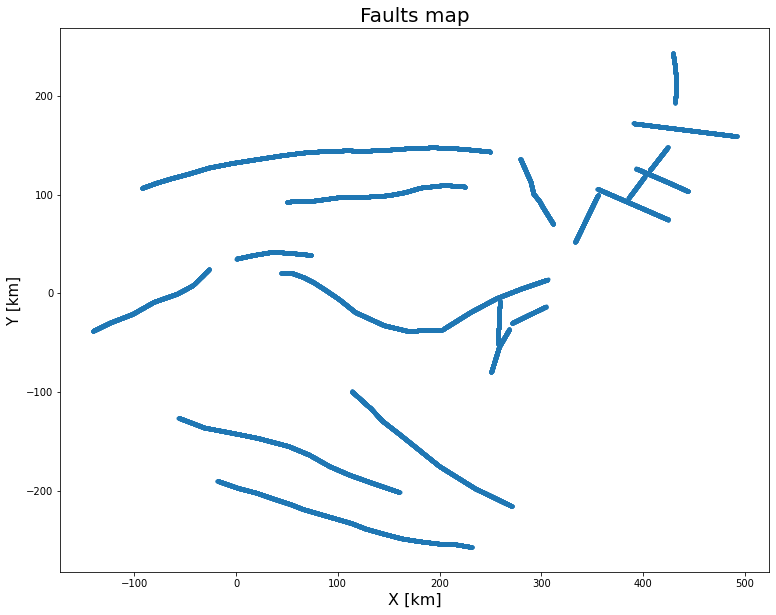

In [5]:
plt.figure(figsize=(12.7, 10))
plt.plot(faults.POINT_X, faults.POINT_Y, linestyle = 'none', marker = '.')

plt.xlabel('X [km]', fontsize=16)
plt.ylabel('Y [km]', fontsize=15)
plt.title('Faults map', fontsize=20)

# plt.savefig('./faults_map.png', bbox_inches='tight', dpi=300)
plt.show()

### Read the exposure profile

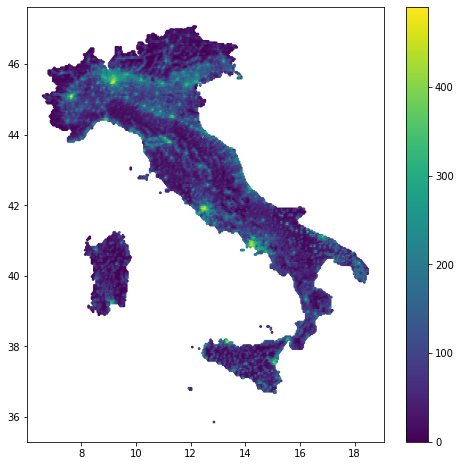

In [6]:
## We get the exposure data from CLIMADA
# from climada.util.api_client import Client
# client2 = Client()
# ITA_nightlight = client2.get_exposures('litpop', properties={'country_iso3alpha':'ITA', 'exponents': '(1,1)'})
# ITA_nightlight.plot_raster()
# ITA_nightlight.gdf.to_csv('./haonan/Italy_LitPop.csv')

# get real exposure
italy = pd.read_csv('./Italy_LitPop.csv')

X_coord = italy.longitude
Y_coord = italy.latitude
Z_coord = italy.value

plt.figure(figsize=(8, 8))
plt.viridis()
plt.scatter(X_coord, Y_coord, marker='.', c=np.power(Z_coord, 0.25), s=12)
plt.colorbar() # power to 0.25 !!!!!!!!!!!!!!!!!!!!!!

In [7]:
X_coord = italy.longitude
Y_coord = italy.latitude

# get new area 
X_exposure = X_coord - 12.4 # longitude 
Y_exposure = Y_coord - 37.4 # latitude

# final fault coordinates
X_exposure = 111.32 * X_exposure * np.cos(Y_exposure/np.pi/180)
Y_exposure = 110.574 * Y_exposure

<Figure size 914.4x720 with 0 Axes>

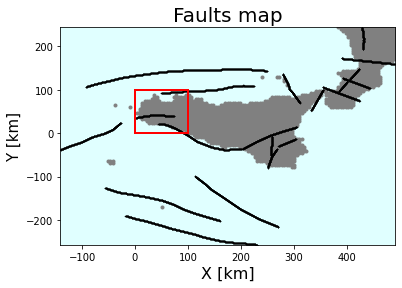

In [8]:
plt.figure(figsize=(12.7, 10))
fig, ax = plt.subplots()
ax.set_facecolor('lightcyan')
plt.plot(X_exposure, Y_exposure, marker='.', color='grey', linestyle='none')
plt.plot(faults.POINT_X, faults.POINT_Y, marker='.', color='black', linestyle='none', markersize=0.5)
plt.xlim((min(faults.POINT_X), max(faults.POINT_X)))
plt.ylim((min(faults.POINT_Y), max(faults.POINT_Y)))

plt.xlabel('X [km]', fontsize=16)
plt.ylabel('Y [km]', fontsize=15)
plt.title('Faults map', fontsize=20)

rect = patches.Rectangle((0, 0), 100, 100, linewidth=2, edgecolor='r', facecolor='none', zorder=10)
ax.add_patch(rect)

# plt.savefig('./faults_map.png', bbox_inches='tight', dpi=300)
plt.show()

In [9]:
# filter all exposure points in the rectangle
x_idx = np.where((X_exposure >= 0) & (X_exposure <= 100))
y_idx = np.where((Y_exposure >= 0) & (Y_exposure <= 100))

filtered_idx = np.intersect1d(x_idx, y_idx)

X_exposure = X_exposure[filtered_idx]
Y_exposure = Y_exposure[filtered_idx]
Z_exposure = Z_coord[filtered_idx]

In [10]:
# create buliding type matrix randomly, but with the specific number of different type
building_type = np.zeros(len(Z_exposure))

num_MA = round(0.8 * len(Z_exposure)) # 80% of the buildings are masonry, builidng_index = 1
num_RC = len(Z_exposure) - num_MA # 20% of the buildings are reinforced concrete, builidng_index = 2

builidng_index = np.concatenate([np.ones(num_MA), 2 * np.ones(num_RC)])
np.random.seed(3)
building_type = np.random.choice(builidng_index, size=len(building_type), replace = False)

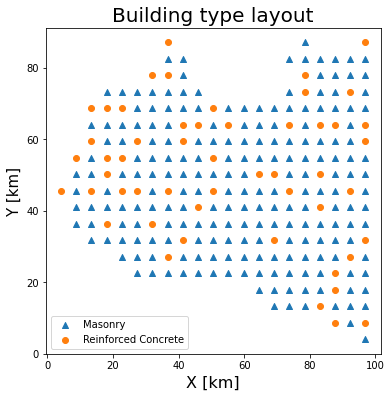

In [11]:
# plot the original exposure map
plt.figure(figsize=(6, 6))

plt.xlabel('X [km]', fontsize=16)
plt.ylabel('Y [km]', fontsize=15)
plt.title('Building type layout', fontsize=20)

ind = np.where(building_type==1)
plt.scatter(X_exposure.iloc[ind], Y_exposure.iloc[ind], marker='^')

ind = np.where(building_type==2)
plt.scatter(X_exposure.iloc[ind], Y_exposure.iloc[ind], marker='o')

plt.legend(['Masonry', 'Reinforced Concrete'], loc='lower left')

# plt.savefig('./Building_type.png', bbox_inches='tight', dpi=300)
plt.show()

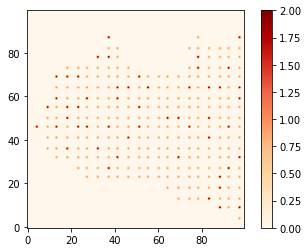

In [12]:
# Grid for building type

# since one point in assets map shows a sum of neibouring area, 
# we don't need to interpolate the value in building type map and assets map

# initialize the building type grid
B_grid = np.zeros([10000])
# initialize the assets grid
A_grid = np.zeros([10000])

# round the coordinates to make later calculation easier
ind = np.where(building_type==1)
ind_x = pd.to_numeric(round(X_exposure.iloc[ind]), downcast="integer")
ind_y = pd.to_numeric(round(Y_exposure.iloc[ind]), downcast="integer")
B_grid[np.matrix(ind_x) + np.matrix(ind_y) * 100] = 1
A_grid[np.matrix(ind_x) + np.matrix(ind_y) * 100] = Z_exposure.iloc[ind]

ind = np.where(building_type==2)
ind_x = pd.to_numeric(round(X_exposure.iloc[ind]), downcast="integer")
ind_y = pd.to_numeric(round(Y_exposure.iloc[ind]), downcast="integer")

B_grid[np.matrix(ind_x) + np.matrix(ind_y) * 100] = 2
A_grid[np.matrix(ind_x) + np.matrix(ind_y) * 100] = Z_exposure.iloc[ind]

B_grid = B_grid.reshape(100, 100)
A_grid = A_grid.reshape(100, 100)

plt.imshow(B_grid, cmap=plt.cm.OrRd)
plt.colorbar()
plt.gca().invert_yaxis()

In [13]:
# Compact building type array

# plot_m = eliminate_zero(B_grid)

# plt.imshow(plot_m, cmap=plt.cm.OrRd, extent = [X_exposure.min() , X_exposure.max(), Y_exposure.max(), Y_exposure.min()])
# plt.colorbar()
# plt.gca().invert_yaxis()

# Fragility Curves

In [14]:
DS_num = 4
DS = np.array([0.02, 0.1, 0.5, 1]) # 4 damage states are considered
g = 9.8
PGA = np.arange(0, 0.505, 0.005)
dis_num = PGA.shape[0]

# Reinforced Concrete – regular, no ductile, and low-rise design (RC)
RC_DS = np.ones([DS_num, dis_num])
RC_DS[0,:] = lognorm.cdf(PGA*g, s=0.031, scale=np.exp(0.09))
RC_DS[1,:] = lognorm.cdf(PGA*g, s=0.06, scale=np.exp(0.13))
RC_DS[2,:] = lognorm.cdf(PGA*g, s=0.101, scale=np.exp(0.263))
RC_DS[3,:] = lognorm.cdf(PGA*g, s=0.132, scale=np.exp(0.35))

# Masonry – low-rise design (MA)
MA_DS = np.ones([DS_num, dis_num])
MA_DS[0,:] = lognorm.cdf(PGA*g, s=0.053, scale=np.exp(0.141))
MA_DS[1,:] = lognorm.cdf(PGA*g, s=0.056, scale=np.exp(0.2))
MA_DS[2,:] = lognorm.cdf(PGA*g, s=0.058, scale=np.exp(0.265))
MA_DS[3,:] = lognorm.cdf(PGA*g, s=0.055, scale=np.exp(0.315))

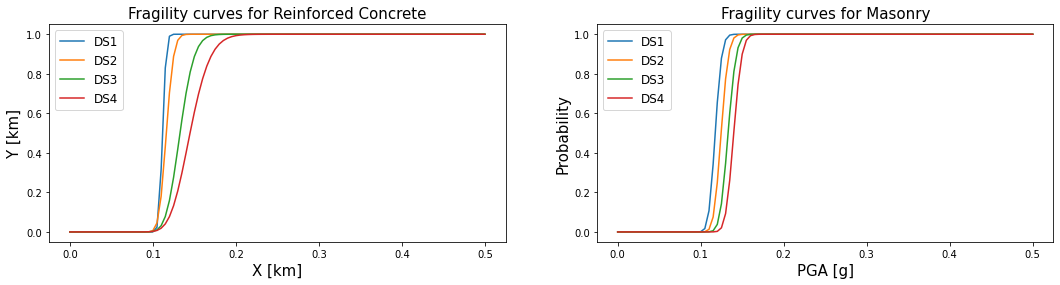

In [15]:
plt.figure(figsize=(18, 4))
plt.subplot(1,2,1)
plt.plot(PGA, RC_DS[0,:])
plt.plot(PGA, RC_DS[1,:])
plt.plot(PGA, RC_DS[2,:])
plt.plot(PGA, RC_DS[3,:])
plt.legend(['DS1','DS2', 'DS3', 'DS4'], fontsize=12)
plt.xlabel('X [km]', fontsize=15)
plt.ylabel('Y [km]', fontsize=15)
plt.title('Fragility curves for Reinforced Concrete', fontsize=15)

plt.subplot(1,2,2)
plt.plot(PGA, MA_DS[0,:])
plt.plot(PGA, MA_DS[1,:])
plt.plot(PGA, MA_DS[2,:])
plt.plot(PGA, MA_DS[3,:])
plt.legend(['DS1','DS2', 'DS3', 'DS4'], fontsize=12)
plt.xlabel('PGA [g]', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.title('Fragility curves for Masonry',fontsize=15)

# plt.savefig('./FC.png', bbox_inches='tight', dpi=300)
plt.show()

# Vulnerability Curves

Text(0.5, 1.0, 'Vulneralbility curve for Masonry')

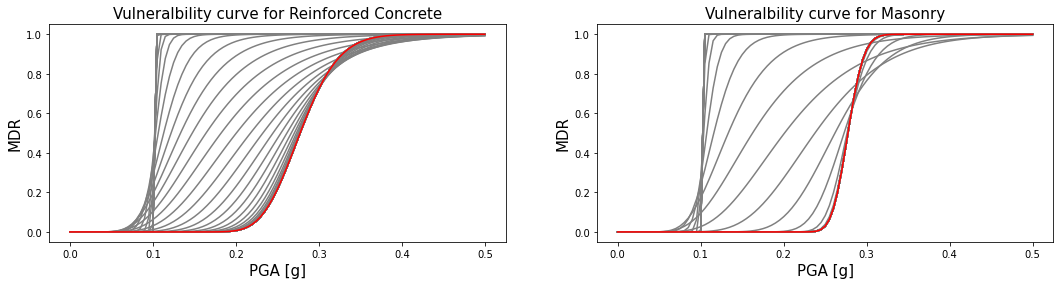

In [16]:
plt.figure(figsize=(18, 4))

# Vulnerability curve of RC
RC_E = np.zeros(PGA.shape)
RC_Var = np.zeros(PGA.shape)
plt.subplot(1,2,1)
for i in range(len(PGA)):
    RC_E[i] = DS[3] * RC_DS[3,i] + DS[2] * (RC_DS[2,i] - RC_DS[3,i]) + DS[1] * (RC_DS[1,i] - RC_DS[2,i]) + DS[0] * (RC_DS[0,i] - RC_DS[1,i])
    RC_Var[i] = (0.132**2 + DS[3]**2) * RC_DS[3,i] + (0.101**2 + DS[2]**2) * (RC_DS[2,i] - RC_DS[3,i]) + (0.06**2 + DS[1]**2) * (RC_DS[1,i] - RC_DS[2,i]) + (0.031**2 + DS[0]**2) * (RC_DS[0,i] - RC_DS[1,i]) - RC_E[i]**2
    plt.plot(PGA, lognorm.cdf(PGA*g, s = np.sqrt(RC_Var[i]), scale=np.exp(RC_E[i])), color = 'grey')
RC_Var = np.median(RC_Var)
RC_E = np.median(RC_E)
plt.plot(PGA, lognorm.cdf(PGA*g, s = np.sqrt(RC_Var), scale=np.exp(RC_E)), color = 'red')
plt.xlabel('PGA [g]', fontsize=15)
plt.ylabel('MDR', fontsize=15)
plt.title('Vulneralbility curve for Reinforced Concrete', fontsize=15)

# Vulnerability curve of Mansonary
MA_E = np.zeros(PGA.shape)
MA_Var = np.zeros(PGA.shape)
plt.subplot(1,2,2)
for i in range(len(PGA)):
    MA_E[i] = DS[3] * MA_DS[3,i] + DS[2] * (MA_DS[2,i] - MA_DS[3,i]) + DS[1] * (MA_DS[1,i] - MA_DS[2,i]) + DS[0] * (MA_DS[0,i] - MA_DS[1,i])
    MA_Var[i] = (0.055**2 + DS[3]**2) * MA_DS[3,i] + (0.058**2 + DS[2]**2) * (MA_DS[2,i] - MA_DS[3,i]) + (0.056**2 + DS[1]**2) * (MA_DS[1,i] - MA_DS[2,i]) + (0.053**2 + DS[0]**2) * (MA_DS[0,i] - MA_DS[1,i]) - MA_E[i]**2
    plt.plot(PGA, lognorm.cdf(PGA*g, s = np.sqrt(MA_Var[i]), scale=np.exp(MA_E[i])), color = 'grey')
MA_Var = np.median(MA_Var)
MA_E = np.median(MA_E)
plt.plot(PGA, lognorm.cdf(PGA*g, s = np.sqrt(MA_Var), scale=np.exp(MA_E)), color = 'red')
plt.xlabel('PGA [g]', fontsize=15)
plt.ylabel('MDR', fontsize=15)
plt.title('Vulneralbility curve for Masonry', fontsize=15)

# plt.savefig('./VC_CI.png', bbox_inches='tight', dpi=300)

Text(0.5, 1.0, 'Vulnerability curves')

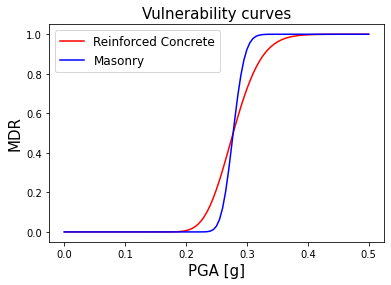

In [17]:
plt.plot(PGA, lognorm.cdf(PGA*g, s = np.sqrt(RC_Var), scale=np.exp(RC_E)), color = 'red')
plt.plot(PGA, lognorm.cdf(PGA*g, s = np.sqrt(MA_Var), scale=np.exp(MA_E)), color = 'blue')
plt.xlabel('PGA [g]', fontsize=15)
plt.ylabel('MDR', fontsize=15)
plt.legend(['Reinforced Concrete', 'Masonry'], fontsize=12)
plt.title('Vulnerability curves', fontsize=15)

# plt.savefig('./VC.png', bbox_inches='tight', dpi=300)

# Main part of our codes: get the event loss table

### We commented three `for` loop here to get the code run in short time.
### !!! Please change the `for` loop to the upper one to get the whole Event Table

In [18]:
# the main loop to get the intensity(PGA) grid, MDR grid and the mean PGA for hazard map

EventTable = pd.DataFrame(columns=['Source','Size','Rate', 'Loss'])

Mmax = get_magnitude(max(faults['TOTALL']))
Mmin = 5
dM = 0.1
I_mean = np.zeros([len(np.arange(Mmin, Mmax, dM)), 100, 100])


### for M_idx, Mi in enumerate(np.arange(Mmin, Mmax, dM)): ### !!!!!!!!!!! uncomment here
for M_idx, Mi in enumerate(np.arange(6.7, 6.71, dM)):
    
    Mi = round(Mi, 2)
    ratei = get_rate(Mi)
    
    I_sum = np.zeros([100, 100])
    
    ### for source_i in faults.IDSOURCE.unique(): ### !!!!!!!!!!! uncomment here
    for source_i in [faults.IDSOURCE.unique()[0]]:
        fault_now = faults.loc[faults.IDSOURCE == source_i, :]
        totalL = fault_now.TOTALL.unique()[0]
        L = get_length(Mi)
        if L > totalL: # skip faults that cannot produce such magnitude
            continue

        number_of_point = math.ceil(L / dL) + 1

        # get index of starting point of every event of the current magnitude, at the current fault
        if (fault_now.shape[0] / number_of_point) == math.ceil(fault_now.shape[0] / number_of_point): # divisible
            fault_idx_list = list(fault_now.index[::number_of_point])
        else: # not divisible, thus plus one more event starting from the end point backwards
            fault_idx_list = list(fault_now.index[::number_of_point])
            fault_idx_list[-1] = fault_now.shape[0] - number_of_point
            
        # when an earthquake-induced segment of fault is longer than 95% of the total fault, remove the second
        if L > totalL * 0.95:
            fault_idx_list.pop()
            
        ### for event_idx in fault_idx_list:  ### !!!!!!!!!!! uncomment here
        for event_idx in [fault_idx_list[0]]:
            event_df = fault_now.loc[event_idx : event_idx + number_of_point - 1, :]

            # calculate intensity (PGA) footprint
            r_grid = [min_dis([grid_x[g_i], grid_y[g_i]], event_df) for g_i in range(len(grid_x))]
            r_grid = np.asmatrix(r_grid).reshape(100, 100)
            I_grid = get_intensity(Mi, r_grid)
            I_sum = I_sum + I_grid

            # plt.figure(figsize=(8, 6))
            # im = plt.imshow(I_grid, cmap=plt.cm.OrRd, extent = [X_exposure.min() , X_exposure.max(), Y_exposure.max(), Y_exposure.min()]) # vmin = 0, vmax = 0.5 to change the scale of colorbar
            # plt.colorbar(im)
            # plt.title('Footprint     Magnitude: {}      Source: {}'.format(Mi, source_i), loc = 'left', fontsize=15)
            # plt.xlabel('X [km]', fontsize=15)
            # plt.ylabel('Y [km]', fontsize=15)
            # plt.gca().invert_yaxis()
            # plt.savefig('./footprint_catalogue/'+str(Mi)+'_'+str(source_i)+'_'+str(event_idx)+'.png', bbox_inches='tight', dpi=300)

            ### plot and save plot here
            MDR_grid = get_MDRgrid(I_grid, B_grid)
            L_grid = MDR_grid * A_grid
            total_loss = sum(sum(L_grid))
            
            # plt.figure(figsize=(8, 6))
            # im = plt.imshow(eliminate_zero(MDR_grid), cmap=plt.cm.OrRd, extent = [X_exposure.min() , X_exposure.max(), Y_exposure.max(), Y_exposure.min()]) # vmin = 0, vmax = 0.5 to change the scale of colorbar
            # plt.colorbar(im)
            # plt.title('   MDR        Magnitude: {}     Source: {}'.format(Mi, source_i), loc = 'left', fontsize=15)
            # plt.gca().invert_yaxis()
            # plt.xlabel('X [km]', fontsize=15)
            # plt.ylabel('Y [km]', fontsize=15)
            # plt.savefig('./MDR_catalogue/'+str(Mi)+'_'+str(source_i)+'_'+str(event_idx)+'.png', bbox_inches='tight', dpi=300)
            
            EventTable.loc[len(EventTable)] = [source_i, Mi, ratei, total_loss]
        
    I_mean[M_idx, :, :] = I_sum / sum(EventTable.Size == Mi)
    print('now finish Magnitude: {}'.format(Mi))         

now finish Magnitude: 6.7


Text(0, 0.5, 'Y [km]')

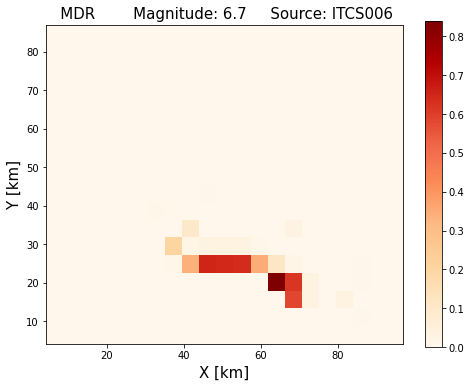

In [19]:
plt.figure(figsize=(8, 6))
im = plt.imshow(np.power(eliminate_zero(MDR_grid),0.1), cmap=plt.cm.OrRd, extent = [X_exposure.min() , X_exposure.max(), Y_exposure.max(), Y_exposure.min()]) # vmin = 0, vmax = 0.5 to change the scale of colorbar
plt.colorbar(im)
plt.title('   MDR        Magnitude: {}     Source: {}'.format(Mi, source_i), loc = 'left', fontsize=15)
plt.gca().invert_yaxis()
plt.xlabel('X [km]', fontsize=15)
plt.ylabel('Y [km]', fontsize=15)
# plt.savefig('./MDR_catalogue/'+str(Mi)+'_'+str(source_i)+'_'+str(event_idx)+'.png', bbox_inches='tight', dpi=300)

Text(0, 0.5, 'Y [km]')

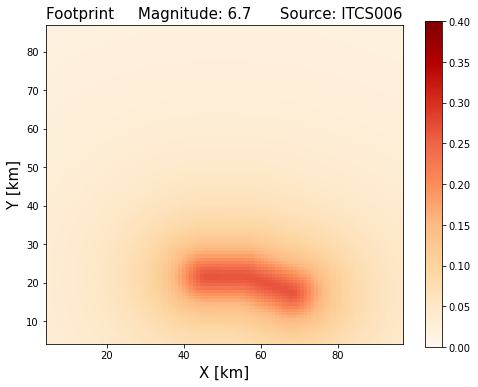

In [20]:
plt.figure(figsize=(8, 6))
im = plt.imshow(I_grid, cmap=plt.cm.OrRd, vmin=0, vmax=0.4, extent = [X_exposure.min() , X_exposure.max(), Y_exposure.max(), Y_exposure.min()]) # vmin = 0, vmax = 0.5 to change the scale of colorbar
plt.colorbar(im)
plt.gca().invert_yaxis()
plt.title('Footprint     Magnitude: {}      Source: {}'.format(Mi, source_i), loc = 'left', fontsize=15)
plt.xlabel('X [km]', fontsize=15)
plt.ylabel('Y [km]', fontsize=15)
# plt.savefig('./footprint_catalogue/'+str(Mi)+'_'+str(source_i)+'_'+str(event_idx)+'.png', bbox_inches='tight', dpi=300)

In [21]:
# saveing the data we got

# EventTable.to_csv('EventTable.csv')
# np.save('I_mean.npy', I_mean)

# load the whole dataset
I_mean = np.load('./I_mean.npy')
EventTable = pd.read_csv('./EventTable.csv')

## Hazard curve and hazard map

In [31]:
Mmax = get_magnitude(max(faults['TOTALL']))
Mmin = 5
dM = 0.1
Mi = np.arange(Mmin, Mmax, dM)

# calculate the rate of earthquakes of magnitude Mi
a = 5; b = 1 # double-truncated Gutenberg-Richter magnitude-frequency distribution, slides P49 chap2_Hazard
ratei = 10 ** (a - b * (Mi - dM / 2)) - 10 ** (a - b * (Mi + dM / 2))

# to get the hazard curve for given location
I_range = 10**np.arange(-3, 1, .1)

nev = len(Mi)
loc_indx = 50
loc_indy = 50
Pr = get_hazrad_curve(I_range, I_mean[:,loc_indx,loc_indy], nev)

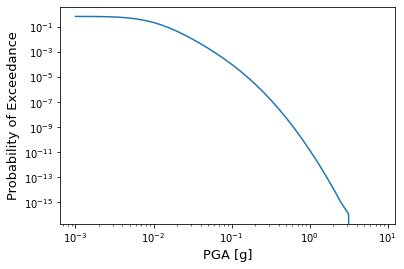

In [32]:
plt.loglog(I_range, Pr)
plt.xlabel('PGA [g]', fontsize=13)
plt.ylabel('Probability of Exceedance', fontsize=13)

plt.savefig('./50_Hazard_curve.png', bbox_inches='tight', dpi=300)

In [24]:
T_ret = [10, 50, 100, 1000] # return period: 100 years
PGA_hazrad_map_plot = np.zeros([len(T_ret),len(x),len(y)])

for t_ind in range(len(T_ret)):
    PGA_hazard_map = np.zeros([len(x)*len(y)])

    for loc_indx in range(len(x)):
        for loc_indy in range(len(y)):
            PGA_hazard_map[loc_indx + loc_indy * len(x)] = get_PGA4hazard_map(T_ret[t_ind], I_range, I_mean[:, loc_indx, loc_indy], nev)

    # PGA_hazard_map = PGA_hazard_map.reshape(len(x),len(y))
    PGA_hazrad_map_plot[t_ind, :, :] = PGA_hazard_map.reshape(len(x),len(y))

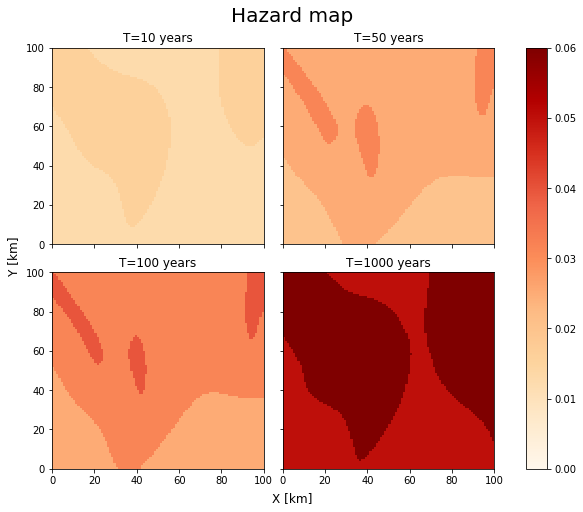

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 7), sharex=True, sharey=True, constrained_layout=True)
# plt.figure(figsize=(5, 8))
n=0
for ax in axes.flat:
    im = ax.pcolormesh(PGA_hazrad_map_plot[n, :, :], cmap=plt.cm.OrRd, vmin=0, vmax=0.06)
    ax.set_title('T='+str(T_ret[n])+' years', size = 12)
    n=n+1

fig.colorbar(im,ax=axes)
fig.supxlabel('X [km]', fontsize=12) # need newest version of matplotlib
fig.supylabel('Y [km]', fontsize=12)
fig.suptitle('Hazard map', fontsize=20)

plt.savefig('./Hazard_map.png', bbox_inches='tight', dpi=300)
plt.show()

## Calculate the EP curve/AAL/Expected loss

In [26]:
# the EventTable we got previously. For convenience, we read from file
df_EventTable = pd.read_csv('./EventTable.csv')

# df_ET = df_EventTable.sort_values(by=['Rate'], ascending=True)
df_ET = df_EventTable.sort_values(by=['Loss'], ascending=False)
# df_ET

### EP curve

In [27]:
pi= df_ET['Rate']
EP = np.zeros(len(pi))

for n in range(len(EP)):
    EP[n] = 1 - np.prod(1 -np.asmatrix( pi[0:n+1]))

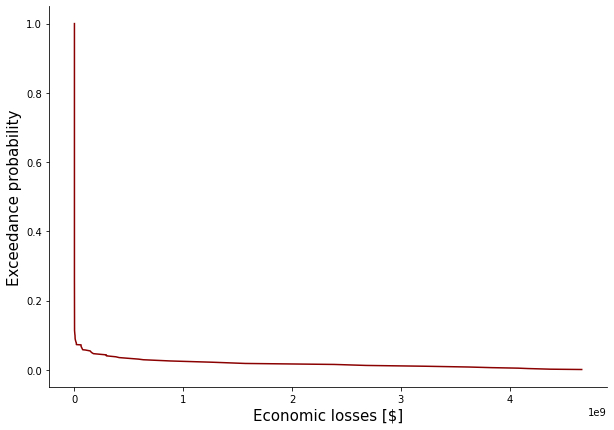

In [28]:
fig, axs = plt.subplots(1,1, figsize = (10,7))
plt.plot(df_ET['Loss'], EP, color = 'darkred')
plt.xlabel('Economic losses [$]', fontsize=15)
plt.ylabel('Exceedance probability', fontsize=15)
# plt.title('EP curve', size = 14)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False);

plt.savefig('EP_curve.png', bbox_inches='tight', dpi=300)


### Calculate the average annual loss

In [29]:
Li = df_ET['Loss']
print('AAL =', sum(pi*Li), '$')

AAL = 76388271.88018923 $


### Update the loss table

In [30]:
EL = Li * pi

df_ET.insert(len(df_ET.columns), 'Expected loss', EL.to_numpy(), True)

df_ET.to_csv('EventLossTable.csv')